In [1]:
from collections import defaultdict
import gymnasium as gym
import gym_simplegrid
import matplotlib
import numpy as np
import os
import shutil
import torch
import torchvision
import json
import copy
# from torch.utils.tensorboard import SummaryWriter
import scipy
import matplotlib.pyplot as plt
# from logger import Logger
from typing import Dict, List, Tuple
from collections import deque
import random


In [2]:
class AverageMeter(object):
    def __init__(self):
        self._sum = 0
        self._count = 0

    def update(self, value, n=1):
        self._sum += value
        self._count += n

    def value(self):
        return self._sum / max(1, self._count)


class MetersGroup(object):
    def __init__(self, file_name):
        self._file_name = file_name
        if os.path.exists(file_name):
            os.remove(file_name)

        self._meters = defaultdict(AverageMeter)

    def log(self, key, value, n=1):
        self._meters[key].update(value, n)

    def _prime_meters(self):
        data = dict()
        for key, meter in self._meters.items():
            data[key] = meter.value()
        return data

    def _dump_to_file(self, data):
        with open(self._file_name, 'a') as f:
            f.write(json.dumps(data) + '\n')

    def dump(self, info:dict):
        if len(self._meters) == 0:
            return
        data = self._prime_meters()
        data = {**info, **data}
        self._dump_to_file(data)
        self._meters.clear()


class Logger(object):
    def __init__(self, log_paths:dict):
        self._log_paths = log_paths
        self.episodic_log_path = log_paths["episodic"]
        self.avg_meter_log_path = log_paths["avg_meter"]
        self._mg = MetersGroup(
           self.avg_meter_log_path
        )
        
    def dump_episodic_data(self, data):
        with open(self.episodic_log_path, 'a') as f:
            f.write(json.dumps(data) + '\n')

    def log(self, key, value, n=1):
        self._mg.log(key, value, n)


    def dump(self, info:dict):
        self._mg.dump(info=info)

### Define Replay Buffer

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_dim = obs_dim
        self.size = size
        self.batch_size = batch_size

        self.reset()
    
    def reset(self):
        if self.obs_dim == 1:
            self.obs_buf = np.zeros([self.size], dtype=np.int32)
            self.next_obs_buf = np.zeros([self.size], dtype=np.int32)
        else:
            self.obs_buf = np.zeros([self.size, self.obs_dim], dtype=np.float32)
            self.next_obs_buf = np.zeros([self.size, self.obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([self.size], dtype=np.int32)
        self.rews_buf = np.zeros([self.size], dtype=np.float32)
        self.done_buf = np.zeros(self.size, dtype=np.float32)
        self.prob_acts_buf = np.zeros(self.size, dtype=np.float32)
        self.max_size, self.batch_size = self.size, self.batch_size        
        self.ptr, self.size = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
        prob_act: float
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.prob_acts_buf[self.ptr] = prob_act
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                    prob_acts=self.prob_acts_buf[idxs])

    def __len__(self) -> int:
        return self.size

### Define the agents

In [4]:
class Agent:
    def __init__(self, alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_decay):
        self.action_space = action_space
        self.n_states = observation_space.n
        self.n_actions = action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps_start
        self.eps_min = eps_end
        self.eps_decay = eps_decay
    
    def softmax(x, temperature):
        e_x = np.exp((x - np.max(x)) / temperature)  # subtract max(x) for numerical stability
        return e_x / e_x.sum(axis=0)

    def choose_action(self, state, softmax=False):
        if softmax:
            # compute softmax probability given self.Q[state, :]
            prob = self.softmax(self.Q[state, :], temperature=1.0)
            action = np.random.choice(self.n_actions, p=prob)
            return action
        if np.random.random() > self.eps:
            action = np.argmax(self.Q[state, :])
            #if there are multiple actions with the same value, choose randomly
            if np.sum(self.Q[state, :] == self.Q[state, action]) > 1:
                action = np.random.choice(np.where(self.Q[state, :] == self.Q[state, action])[0])
            
            action_prob = 1-self.eps + self.eps/self.n_actions
        else:
            action = self.action_space.sample()
            action_prob = self.eps/self.n_actions
         
        self.decay_eps()
        return action, action_prob

    def decay_eps(self):
        self.eps = self.eps * self.eps_decay if self.eps > self.eps_min else self.eps_min
        
    # define abstract method
    def learn(self, state, action, reward, state_):
        pass


class Q_Agent(Agent):
    def __init__(self, alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec, random_value_init, **kwargs):
        super().__init__(alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec)
        self.action_space = action_space
        self.observation_space = observation_space
        self.n_states = observation_space.n
        self.n_actions = action_space.n
        self.random_value_init = random_value_init
        self.reset_Q(self.random_value_init)

        
    def learn(self, state, action, reward, state_, done, prob_action):
        # check if done is a numpy array
        
        Q_error = reward + self.gamma * np.max(self.Q[state_, :]) * (1-done) - self.Q[state, action]
        self.Q[state, action] = self.Q[state, action] + self.alpha * Q_error
        return {
            "Q_error": np.mean(Q_error), 
            "maxQ": np.max(self.Q),
            "Q(s,a)": np.mean(self.Q[state, action]),
            "eps": self.eps
            }

    def reset_Q(self, random):
        if random:
            # random from uniform distribution between a and b
            a, b = -1, 1
            self.Q = np.random.uniform(a, b, (self.n_states, self.n_actions))
        else:
            self.Q = np.zeros((self.n_states, self.n_actions))

class DoubleQ_Agent(Agent):
    def __init__(self, alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec, random_value_init, **kwargs):
        super().__init__(alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec)
        self.action_space = action_space
        self.observation_space = observation_space
        self.n_states = observation_space.n
        self.n_actions = action_space.n
        self.random_value_init = random_value_init
        self.reset_Q(self.random_value_init)

        
    def learn(self, state, action, reward, state_, done, prob_action):
        # check if done is a numpy array
        if np.random.random() > 0.5:
            A1 = random.choice(np.where(self.Q[state_, :] == np.max(self.Q[state_, :]))[0])
            Q_error = reward + self.gamma * self.Q_[state_, A1] * (1-done) - self.Q[state, action]
            self.Q[state, action] += self.alpha * Q_error
        else:
            A2 = random.choice(np.where(self.Q_[state_, :] == np.max(self.Q_[state_, :]))[0])
            Q_error = reward + self.gamma * self.Q[state_, A2] * (1-done) - self.Q_[state, action]
            self.Q_[state, action] += self.alpha * Q_error

        return {
            "Q_error": np.mean(Q_error), 
            "maxQ": np.max(self.Q),
            "Q(s,a)": np.mean(self.Q[state, action]),
            "eps": self.eps
            }
    def choose_action(self, state, softmax=False):
        # given state, sum Q and Q_ and choose action with highest value
        Q_sum = (self.Q[state, :] + self.Q_[state, :])/2
        if softmax:
            # compute softmax probability given self.Q[state, :]
            prob = self.softmax(Q_sum, temperature=1.0)
            action = np.random.choice(self.n_actions, p=prob)
            return action
        if np.random.random() > self.eps:
            action = np.argmax(Q_sum)
            #if there are multiple actions with the same value, choose randomly
            if np.sum(Q_sum == Q_sum[action]) > 1:
                action = np.random.choice(np.where(Q_sum == Q_sum[action])[0])
            
            action_prob = 1-self.eps + self.eps/self.n_actions
        else:
            action = self.action_space.sample()
            action_prob = self.eps/self.n_actions
        self.decay_eps()
        return action, action_prob

    def reset_Q(self, random):
        if random:
            # random from uniform distribution between a and b
            a, b = -1, 1
            self.Q = np.random.uniform(a, b, (self.n_states, self.n_actions))
            self.Q_ = np.random.uniform(a, b, (self.n_states, self.n_actions))
        else:
            self.Q = np.zeros((self.n_states, self.n_actions))
            self.Q_ = np.zeros((self.n_states, self.n_actions))

class VQ_Agent(Agent):
    def __init__(self, alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec, random_value_init, **kwargs):
        super().__init__(alpha, gamma, action_space, observation_space, eps_start, eps_end, eps_dec)
        self.action_space = action_space
        self.observation_space = observation_space
        self.n_states = observation_space.n
        self.n_actions = action_space.n
        self.random_value_init = random_value_init
        self.alpha_v = kwargs["alpha_v"]
        self.alpha_q = kwargs["alpha_q"]
        self.reset_value_functions(random=self.random_value_init)
        self.importance_sampling = kwargs["importance_sampling"]

    def reset_value_functions(self, random):
        if random:
            # random from uniform distribution between a and b
            a, b = -1, 1
            self.V = np.random.uniform(a, b, self.n_states)
            self.Q = np.random.uniform(a, b, (self.n_states, self.n_actions))
            
        else:
            self.V = np.zeros(self.n_states)
            self.Q = np.zeros((self.n_states, self.n_actions))

    def learn(self, state, action, reward, state_, done, prob_action):
        if self.importance_sampling:
            max_action = np.argmax(self.Q[state, :])
            bool_mask = action == max_action
            bool_mask = bool_mask.astype(float)
            current_action_prob = (1-self.eps + self.eps/self.n_actions) * bool_mask + (self.eps/self.n_actions) * (1-bool_mask)
            #importance sampling ratio
            importance_sampling_ratio = current_action_prob / prob_action
            # get an array where elements are 1 when elements in importance_sampling_ratio at the same indice that are between [0.8,1.2]
            # and 0 otherwise
            
            # 
            target = reward + self.gamma * self.V[state_] * (1-done)
            V_error = importance_sampling_ratio * target - self.V[state]
            Q_error = importance_sampling_ratio * target - self.Q[state, action]
            mask_ = np.logical_and(importance_sampling_ratio > 0.9, importance_sampling_ratio < 1.1)
            mask_ = mask_.astype(float)
            V_error = V_error * mask_
            Q_error = Q_error * mask_
        else:
            V_error = reward + self.gamma * self.V[state_] * (1-done) - self.V[state]
            Q_error = reward + self.gamma * self.V[state_] * (1-done)- self.Q[state, action]

        self.V[state] = self.V[state] + self.alpha_v * V_error
        # self.Q[state, action] = self.V[state_]
        self.Q[state, action] = self.Q[state, action] + self.alpha_q * Q_error

        return {
            "V_error": np.mean(V_error), 
            "Q_error": np.mean(Q_error), 
            "max_VQ_diff": np.max(np.abs(self.V - np.max(self.Q, axis=1))),
            "maxV": np.max(self.V),
            "maxQ": np.max(self.Q),
            "V(s)": np.mean(self.V[state]),
            "Q(s,a)": np.mean(self.Q[state, action]),
            "is_ratio": np.mean(importance_sampling_ratio) if self.importance_sampling else 0, 
            "mask_": np.mean(mask_) if self.importance_sampling else 0,
            "bool_mask": np.mean(bool_mask) if self.importance_sampling else 0,
            "eps": self.eps
            }

    def learn_syncVQ(self, state, action, reward, state_, done, prob_action):
        # deep copy self.V and self.Q
        self.V_ = copy.deepcopy(self.V)
        self.Q_ = copy.deepcopy(self.Q)

        if self.importance_sampling:
            max_action = np.argmax(self.Q_[state, :])
            bool_mask = action == max_action
            bool_mask = bool_mask.astype(float)
            current_action_prob = (1-self.eps + self.eps/self.n_actions) * bool_mask + (self.eps/self.n_actions) * (1-bool_mask)
            #importance sampling ratio
            importance_sampling_ratio = current_action_prob / prob_action
            # get an array where elements are 1 when elements in importance_sampling_ratio at the same indice that are between [0.8,1.2]
            # and 0 otherwise
            
            # 
            target = reward + self.gamma * self.V_[state_] * (1-done)
            V_error = importance_sampling_ratio * target - self.V_[state]
            Q_error = importance_sampling_ratio * target - self.Q_[state, action]
            mask_ = np.logical_and(importance_sampling_ratio > 0.9, importance_sampling_ratio < 1.1)
            mask_ = mask_.astype(float)
            V_error = V_error * mask_
            Q_error = Q_error * mask_
        else:
            V_error = reward + self.gamma * self.V_[state_] * (1-done) - self.V_[state]
            Q_error = reward + self.gamma * self.V_[state_] * (1-done)- self.Q_[state, action]

        self.V_[state] = self.V_[state] + self.alpha_v * V_error
        self.Q_[state, action] = self.Q_[state, action] + self.alpha_q * Q_error
        return {
            "V_error": np.mean(V_error), 
            "Q_error": np.mean(Q_error), 
            "max_VQ_diff": np.max(np.abs(self.V_ - np.max(self.Q_, axis=1))),
            "maxV": np.max(self.V_),
            "maxQ": np.max(self.Q_),
            "V(s)": np.mean(self.V_[state]),
            "Q(s,a)": np.mean(self.Q_[state, action]),
            "is_ratio": np.mean(importance_sampling_ratio) if self.importance_sampling else 0, 
            "mask_": np.mean(mask_) if self.importance_sampling else 0,
            "bool_mask": np.mean(bool_mask) if self.importance_sampling else 0,
            "eps": self.eps
            }


    def sync_VQ(self):
        self.V = copy.deepcopy(self.V_)
        self.Q = copy.deepcopy(self.Q_)



In [5]:
importance_sampling_ratio= np.array([0.5, 0.9, 1.4, 4.0, 1.1])
mask = np.logical_and(importance_sampling_ratio > 0.8, importance_sampling_ratio < 1.2)
print(mask)

[False  True False False  True]


### Define function run

In [6]:
def run(obstacle_map, start_loc, goal_loc, config, repeat_idx, total_steps, logger:Logger):
    
    env = gym.make(
        'SimpleGrid-v0', 
        obstacle_map=obstacle_map, 
        # render_mode='human',
        render_mode=None,
        max_episodic_steps=1000,
    )
    
    # agent = Q_Agent(alpha=0.1, gamma=0.99, action_space=env.action_space, observation_space=env.observation_space, eps_start=0.2, eps_end=0.00, eps_dec=0.99999, random_init=True)
    if config['algo_name'] == 'VQ-learning':
        agent = VQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"], alpha_v=config["alpha_v"], alpha_q=config["alpha_q"], importance_sampling=config["importance_sampling"])
    elif config['algo_name'] == 'Q-learning':
        agent = Q_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"])
    elif config['algo_name'] == 'DoubleQ-learning':
        agent = DoubleQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"])
    else:
        raise ValueError(f"algo_name: {config['algo_name']} not supported")

    replay_buffer = ReplayBuffer(obs_dim=1, size=config['buffer_size'], batch_size=config['batch_size'])
        
    obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
    # done = env.unwrapped.done
    done=False
    truncated = False
    episode_reward = 0
    episode_idx = 0
    learn_info_list = []
    trajectory = [obs]
    n_reset_buffer = 0
    n_learn = 0
    n_on_policy = 0
    running_avg = 1.0
    for step in range(total_steps):
        if done or truncated:
            # print(f'repeat_idx: {repeat_idx} | step: {step} | episode reward:{episode_reward} | maxQ: {np.max(agent.Q)} | eps: {agent.eps}')
            data = {"repeat_idx": repeat_idx, "episode_idx": episode_idx, "step": step, "reward": episode_reward, "maxQ": np.max(agent.Q), "eps": agent.eps}
            # data.update(learn_info)
            logger.dump_episodic_data(data)

            obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
            episode_reward = 0
            episode_idx += 1
            
            # print(f"repeat:{repeat_idx} trajectory: {trajectory} \n")
            # with open("results/temp.log", 'a') as f:
            #     f.write(f"repeat:{repeat_idx} step {step} done {done} truncated {truncated}trajectory: {trajectory}" + '\n')
            # trajectory = [obs]
            
        if (step+1) % 100 == 0:    
            logger.dump({"repeat_idx": repeat_idx,"step": step})
            
        action, action_prob = agent.choose_action(obs)
        new_obs, reward, done, truncated, info = env.step(action)
        replay_buffer.store(obs, action, reward, new_obs, float(done), action_prob)
        if len(replay_buffer) >= replay_buffer.batch_size:
            if config["importance_sampling"]>0:
                trans = replay_buffer.sample_batch()
                if config['syncVQ']:
                    learn_info = agent.learn_syncVQ(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                else:
                    learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                n_learn += 1
                n_on_policy += 1
                # running_avg = (running_avg + np.mean(learn_info['mask_'])) / (n_on_policy + 1)
                # running_avg = running_avg * 0.5 + 0.5 * np.mean(learn_info['mask_'])
                # running_avg = np.mean(buf)
                running_avg = np.mean(learn_info['mask_'])
                if running_avg < config["importance_sampling"]:
                    replay_buffer.reset()
                    n_reset_buffer += 1
                    if config['syncVQ']:
                        agent.sync_VQ()
                    # running_avg = 0
                    # n_on_policy = 0
                else: 
                    pass
                    # print(f"np.mean(l_on_policy): {np.mean(l_on_policy)}")
                
                learn_info.update(
                    {
                        "n_learn": n_learn, 
                        "n_reset_buffer": n_reset_buffer, 
                        "n_on_policy": n_on_policy,
                        "running_avg": running_avg,
                    }
                    )
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                    logger.log(key=k, value=v)
            else:
                trans = replay_buffer.sample_batch()
                learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                        logger.log(key=k, value=v)
        trajectory.append(new_obs)
        # print(f"transition: {obs} -> {action} -> {new_obs} | reward: {reward} | done: {done}")
        # print(learn_info)
        # print(agent.V)
        # print(agent.Q)
        episode_reward += reward
        obs = new_obs


    print(f"n_reset_buffer: {n_reset_buffer}, n_learn: {n_learn}")    
    env.close()           


### Run Repeats

In [34]:
import numpy as np
obstacle_map = [
        "000",
        "000",
        "000",
    ]
start_loc = (1,1)
goal_loc = [(0,0), (2,2)]
map_name = "square"
map_str = np.asarray(obstacle_map, dtype='c')
print(map_str)
map_int = np.asarray(map_str, dtype=int)
print(map_int)

env = gym.make(
    'SimpleGrid-v0', 
    obstacle_map=obstacle_map, 
    # render_mode='human',
    render_mode=None,
)
print(env.observation_space.n)
obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
print(obs)
print(np.zeros(1))

[[b'0' b'0' b'0']
 [b'0' b'0' b'0']
 [b'0' b'0' b'0']]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
9
4
[0.]


In [15]:
# [Load a custom map]
obstacle_map = [
        "0000000",
        "0000000",
        "0000000",
        "1110111",
        "0000000",
        "0000000",
        "0000000",
    ]
start_loc = (0,2)
goal_loc = [(6,2), (1,6)]
map_name = "2rooms"

# obstacle_map = [
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (1,2)]
# map_name = "2row"

# obstacle_map = [
#         "000",
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (2,2)]
# map_name = "square"
n_repeat = 10
total_steps = 60000
config = {
    # "algo_name": "Q-learning",
    # "algo_name": "VQ-learning",
    "algo_name": "DoubleQ-learning",
    "eps_start": 0.3,
    "eps_end": 0.00,
    "eps_decay": 0.99995,
    "alpha": 0.1,
    "gamma": 0.99,
    "random_value_init": True,
    "alpha_v": 0.1,
    "alpha_q": 0.1,
    "buffer_size": 1,
    "batch_size": 1,
    "importance_sampling": 0.0, # this will work as a threshold
    "syncVQ": False,
}
algo_name = config["algo_name"]
log_dir = f"results/{map_name}/{algo_name}/randinit{int(config['random_value_init'])}_eps{config['eps_start']}to{config['eps_end']}_decay{config['eps_decay']}_buffer{config['buffer_size']}_{config['batch_size']}_is{config['importance_sampling']}_syncVQ{int(config['syncVQ'])}_repeat{n_repeat}_steps{total_steps}_test"
print(log_dir)
log_paths = {
    "avg_meter": os.path.join(log_dir, "avg_meter.log"),
    "episodic": os.path.join(log_dir, "episodic.log"),
}
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
for log_path in log_paths.values():
    if os.path.exists(log_path):
        os.remove(log_path)

logger = Logger(log_paths=log_paths)

# algo = "VQ-learning"
# if results/temp.log exists, remove it
if os.path.exists("results/temp.log"):
    os.remove("results/temp.log")
for i_repeat in range(n_repeat):
    run(obstacle_map, start_loc, goal_loc, config=config, repeat_idx=i_repeat, total_steps=total_steps, logger=logger)
    print(f"repeat {i_repeat} done")


results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000_test


n_reset_buffer: 0, n_learn: 0
repeat 0 done
n_reset_buffer: 0, n_learn: 0
repeat 1 done
n_reset_buffer: 0, n_learn: 0
repeat 2 done
n_reset_buffer: 0, n_learn: 0
repeat 3 done
n_reset_buffer: 0, n_learn: 0
repeat 4 done
n_reset_buffer: 0, n_learn: 0
repeat 5 done
n_reset_buffer: 0, n_learn: 0
repeat 6 done
n_reset_buffer: 0, n_learn: 0
repeat 7 done
n_reset_buffer: 0, n_learn: 0
repeat 8 done
n_reset_buffer: 0, n_learn: 0
repeat 9 done


### Define tools for plotting

In [8]:
def extract_data_logfile(
    log_path,
    key_name,
    value_name,
    smooth=10,
    max_key=True,
    interpolate=True,
):

    all_keys = []
    all_values = []
    keys = []
    values = []

    last_idice = []
    with open(log_path, "r") as f:
        # get the last line
        for line in f:
            pass
        last_line = line
        n_repeat = json.loads(line)["repeat_idx"] + 1
    for i in range(n_repeat):
        # count number of lines for repeat i
        n_lines = 0
        with open(log_path, "r") as f:
            for line in f:
                data = json.loads(line)
                if data["repeat_idx"] == i:
                    n_lines += 1
        last_idice.append(n_lines)
    last_idice = np.array(last_idice)
    # each element is the sum of the previous elements
    last_idice = np.cumsum(last_idice)
    last_idice = last_idice - 1

    with open(log_path, "r") as f:
        for i, line in enumerate(f):
            data = json.loads(line)
            if key_name in data and value_name in data:
                keys.append(data[key_name])
                values.append(data[value_name])

            if i in last_idice:
                keys, values = np.array(keys), np.array(values)
                assert smooth < keys.shape[0]
                if smooth > 1 and values.shape[0] > 0:
                    K = np.ones(smooth)
                    ones = np.ones(values.shape[0])
                    values = np.convolve(values, K, "same") / np.convolve(ones, K, "same")
                all_keys.append(np.array(keys))
                all_values.append(np.array(values))
                keys = []
                values = []

    
    if interpolate:
        all_keys_tmp = sorted(all_keys, key=lambda x: x[-1])
        keys = all_keys_tmp[-1] if max_key else all_keys_tmp[0]
        # threshold = keys.shape[0]

        # interpolate
        for idx, (key, value) in enumerate(zip(all_keys, all_values)):
            f = scipy.interpolate.interp1d(key, value, fill_value="extrapolate")
            all_keys[idx] = keys
            all_values[idx] = f(keys)
    else:
        keys = all_keys[-1] 

    all_values = np.array(all_values)
    means = np.mean(all_values, axis=0)
    half_stds = 0.5 * np.std(all_values, axis=0)

    # means, half_stds = [], []
    # for i in range(threshold):
    #     vals = []

    #     for v in all_values:
    #         if i < v.shape[0]:
    #             vals.append(v[i])
    #     if best_k is not None:
    #         vals = sorted(vals)[-best_k:]
    #     means.append(np.mean(vals))
    #     # half_stds.append(0.5 * np.std(vals))
    #     half_stds.append(np.std(vals))

    # means = np.array(means)
    # half_stds = np.array(half_stds)

    # keys = all_keys[-1][:threshold]
    assert means.shape[0] == keys.shape[0]

    return keys, means, half_stds

def plot_data(
    keys,
    means,
    half_stds,
    max_time=None,
    label="DVQN",
    color=None,
    x_label=None,
    y_label=None,
    save_path=False,
):
    if max_time is not None:
        idxs = np.where(keys <= max_time)
        keys = keys[idxs]
        means = means[idxs]
        half_stds = half_stds[idxs]

    plt.rcParams["figure.figsize"] = (5, 3)
    plt.rcParams["figure.dpi"] = 200
    plt.rcParams["font.size"] = 10
    plt.subplots_adjust(left=0.165, right=0.99, bottom=0.16, top=0.95)
    plt.tight_layout()

    plt.plot(keys, means, label=label, color=color)
    plt.locator_params(nbins=10, axis="x")
    plt.locator_params(nbins=10, axis="y")
    # plt.ylim(0, 1050)

    plt.grid(alpha=0.8)
    # ax.title(title)
    plt.fill_between(keys, means - half_stds, means + half_stds, alpha=0.15)
    # plt.legend(loc="lower right", prop={"size": 6}).get_frame().set_edgecolor("0.1")
    # plt.legend(loc="upper left", ncol=1)
    plt.legend(ncol=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    if save_path:
        plt.savefig(f"{save_path}.png")

def plot_metric(log_path, key_name, value_name, x_label, y_label, label_name, interpolate=True, smooth=100, max_key=True, save_path=False):
    keys, means, half_stds = extract_data_logfile(    
        log_path,
        key_name,
        value_name,
        smooth=smooth,
        max_key=max_key,
        interpolate=interpolate,
        )
    pass
    plot_data(
        keys,
        means,
        half_stds,
        max_time=None,
        label=label_name,
        color=None,
        x_label=x_label,
        y_label=y_label,
        save_path=save_path,
    )

In [12]:
# log_dir = 'results/2rooms_randinit0_eps0.5to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000'
log_dir

'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000'

### Plot Episodic Reward

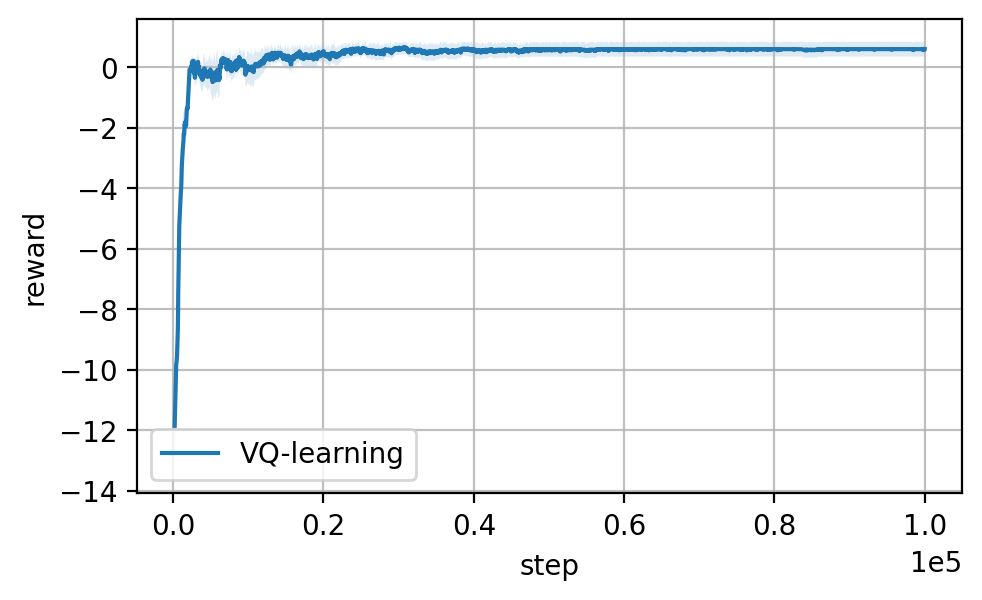

In [95]:
key_name = "step"
value_name = "reward"
# value_name = "maxQ"
x_label = key_name
y_label = value_name
label_name = algo_name
log_path = os.path.join(log_dir, "episodic.log")
save_path = os.path.join(log_dir, "step-reward.png")
# log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

# key_name = "step"
# # value_name = "maxQ"
# value_name = "reward"
# label_name = "VQ-learning1.0"
# log_path = os.path.join('results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10', "episodic.log")
# plot_metric(log_path, key_name, value_name, label_name=label_name, interpolate=True, smooth=10, max_key=True)

### Plot X for avg_meter.log

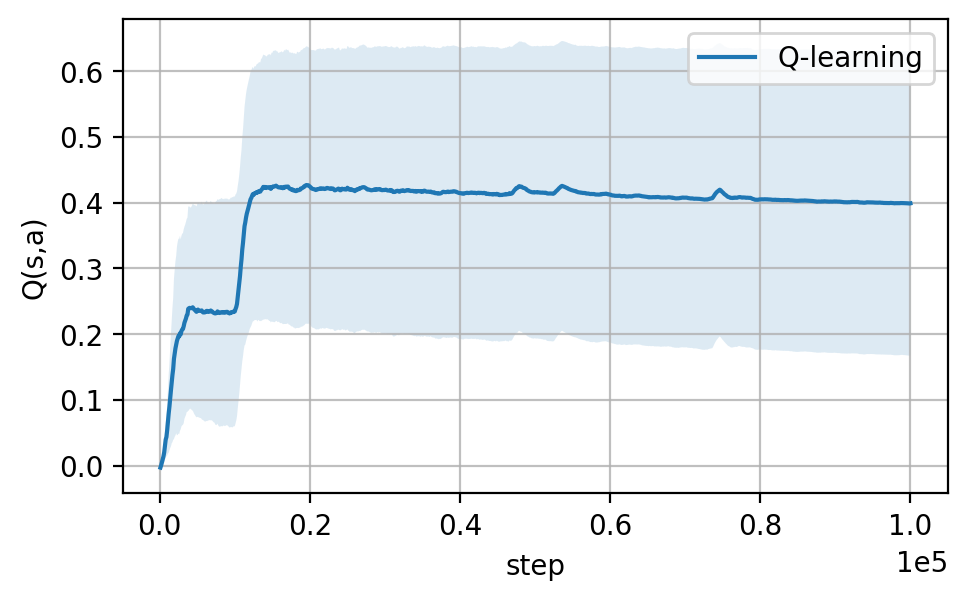

In [60]:
key_name = "step"
value_name = "Q(s,a)"
x_label = key_name
y_label = value_name
label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, "step-Q.png")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

### Plot V and Q

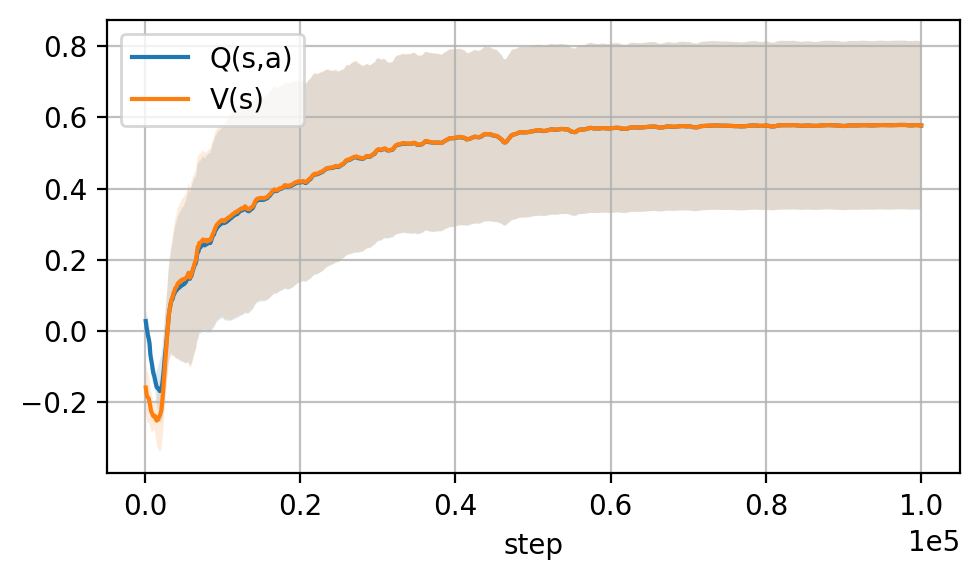

In [96]:

key_name = "step"
value_name = "Q(s,a)"
# value_name = "maxQ"
x_label = key_name
y_label = ''
curve_name = value_name
log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, "step-V-Q.png")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=False, smooth=10, max_key=True, save_path=False)
value_name = "V(s)"
curve_name = value_name
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)


# log_path = os.path.join(log_dir, "avg_meter.log")
# x_label = "step"
# y_label = "Q(s,a)"
# plot_metric(log_path, x_label, y_label, label_name="Q(s,a)", interpolate=False)
# x_label = "step"
# y_label = "V(s)"
# plot_metric(log_path, x_label, y_label, label_name="V(s)", interpolate=False)

### Plot mask_

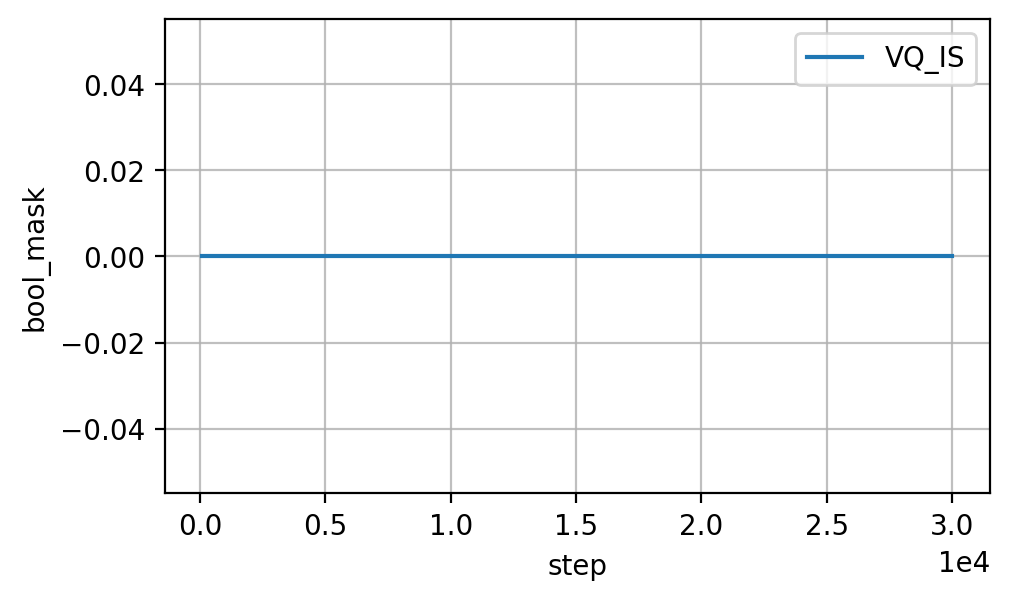

In [383]:
log_path = os.path.join(log_dir, "avg_meter.log")
key_name = x_label = "step"
value_name = y_label = "bool_mask"
label_name = "VQ_IS"
save_path = os.path.join(log_dir, "step-GoodImpSplRate.png")
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)


### Plot all runs

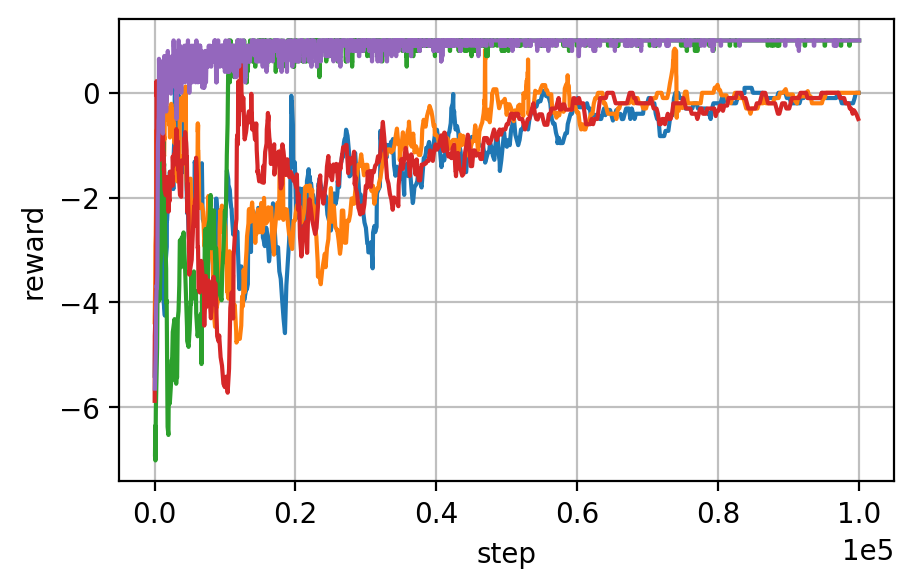

In [61]:
# log_dir = "results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10"
# log_path = os.path.join(log_dir, "avg_meter.log")
log_path = os.path.join(log_dir, "episodic.log")
x_label = "step"
# value_name = "max_VQ_diff"
y_label = "reward"
smooth=10
save_path = os.path.join(log_dir, "step-reward-allruns.png")

last_idice = []
for i in range(n_repeat):
    # count number of lines for repeat i
    n_lines = 0
    with open(log_path, "r") as f:
        for line in f:
            data = json.loads(line)
            if data["repeat_idx"] == i:
                n_lines += 1
    last_idice.append(n_lines)
last_idice = np.array(last_idice)
# each element is the sum of the previous elements
last_idice = np.cumsum(last_idice)
last_idice = last_idice - 1

keys = []
values = []

with open(log_path, "r") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        if x_label in data and y_label in data:
            keys.append(data[x_label])
            values.append(data[y_label])        
        if i in last_idice:
            keys, values = np.array(keys), np.array(values)
            if smooth > 1 and values.shape[0] > 0:
                K = np.ones(smooth)
                ones = np.ones(values.shape[0])
                values = np.convolve(values, K, "same") / np.convolve(ones, K, "same")
            # plot data
            plt.plot(keys, values, label=f"rep_idx: {np.where(last_idice==i)[0][0]}")

            keys = []
            values = []


            
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.grid(alpha=0.8)
# plt.ylim(top=2.0)
# plt.legend(ncol=1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# save the plot to save_path
plt.savefig(f"{save_path}.png")
# plt.close()

### Compare algos

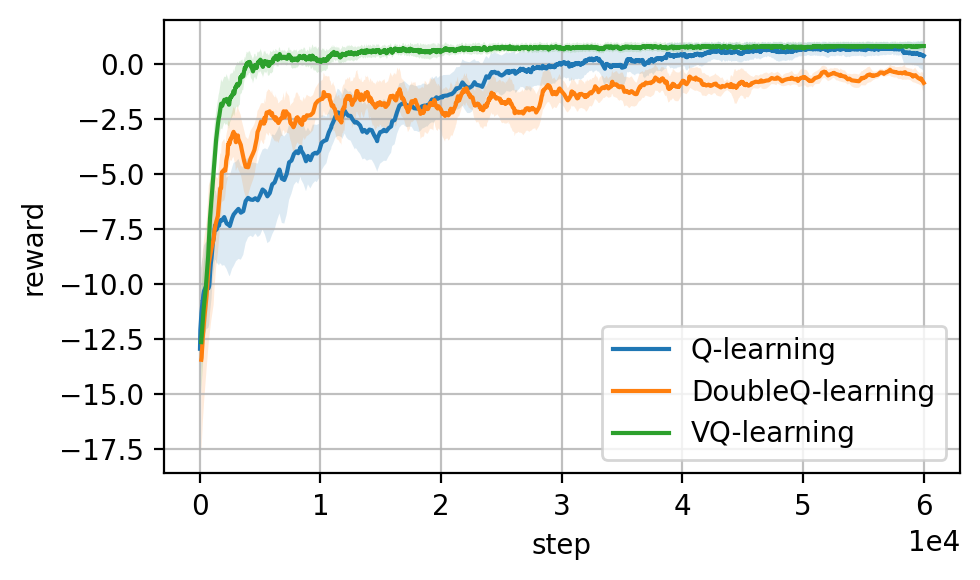

In [13]:
mode = "episodic" # or avg_meter

# [version 1]:
# log_dir1 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# log_dir2 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning"
# log_dir3 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_DoubleQLearning"

# if mode == "episodic":
#     log_path1 = os.path.join(log_dir1, "episodic.log")
#     log_path2 = os.path.join(log_dir2, "episodic.log")
# else:
#     log_path1 = os.path.join(log_dir1, "avg_meter.log")
#     log_path2 = os.path.join(log_dir2, "avg_meter.log")
# save_path1 = os.path.join(log_dir1, "step-reward-compare-algos.png")
# save_path2 = os.path.join(log_dir2, "step-reward-compare-algos.png")
# print(log_path1)
# curve_name1 = "VQ-learning"
# curve_name2 = "Q-learning"
# key_name = x_label = "step"
# value_name = y_label = "reward"
# smooth=10


# plot_metric(log_path1, key_name, value_name, x_label, y_label, label_name=curve_name1, interpolate=True, smooth=10, max_key=True, save_path=False)
# plot_metric(log_path2, key_name, value_name, x_label, y_label, label_name=curve_name2, interpolate=True, smooth=10, max_key=True, save_path=save_path1)

# [version 2]:
log_dirs = {
    # "Q-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning",
    "Q-learning": "results/2rooms/Q-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
    # "DoubleQ-learning" : 'results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps30000',
    "DoubleQ-learning": "results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
    # "VQ-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000",
    "VQ-learning": 'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000'


}

for i, (key, value) in enumerate(log_dirs.items()):
    if mode == "episodic":
        log_path = os.path.join(value, "episodic.log")
    else:
        log_path = os.path.join(value, "avg_meter.log")
    save_path = os.path.join(value, "step-reward-compare-algos.png")
    key_name = x_label = "step"
    value_name = y_label = "reward"
    curve_name = key
    if i == len(log_dirs) - 1:
        plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)
    else:
        plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=False)



# log_dir = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# key_name = "step"
# value_name = "reward"
# # value_name = "maxQ"
# x_label = key_name
# y_label = value_name
# label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
# print(log_path)
# save_path = os.path.join(log_dir, "step-reward.png")
# # log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
# plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=False)